## CLIMB

This report encompasses all the methods, process, and description about the work that has been done during my research for the **CLIMB** project.


## Net Migration Data

$ Migration_{net} = Migration_{in} - Migration_{out} $

In the following section, the objective is to find the mean and the aggregate of net migration in the selected regions of senegal over the years to observe and understand the pattern. 

In [ ]:
# save the env [freeze] to requirements.txt
!python3 -m pip freeze > requirements.txt

In [1]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
from shapely.geometry import mapping # mapping is used to convert geometries to GeoJSON format
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
shapefile_path = 'aoi_new.geojson'

raster_paths_dict = {
    2000: 'NetMigrDataset_2023March/GLOBAL_RASTER/NetMigr_2000.tif',
    2005: 'NetMigrDataset_2023March/GLOBAL_RASTER/NetMigr_2005.tif',
    2010: 'NetMigrDataset_2023March/GLOBAL_RASTER/NetMigr_2010.tif',
    2015: 'NetMigrDataset_2023March/GLOBAL_RASTER/NetMigr_2015.tif',
    2020: 'NetMigrDataset_2023March/GLOBAL_RASTER/NetMigr_2020.tif',
}


def get_masks_and_stats(raster_paths_dict, shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    results_dict = {}
    summary_rows = []

    for year, raster_path in raster_paths_dict.items():
        with rasterio.open(raster_path) as src:
            if gdf.crs != src.crs:
                gdf = gdf.to_crs(src.crs)

            for idx, row in gdf.iterrows():
                geom = [mapping(row['geometry'])]
                try:
                    out_image, _ = mask(src, geom, crop=True)
                    data = out_image[0]
                    valid_data = data[data != src.nodata]
                    valid_data = valid_data.astype(np.float32)

                    if idx not in results_dict:
                        results_dict[idx] = {}

                    # Store for image display
                    mask_array = np.where(data != src.nodata, data, np.nan)
                    results_dict[idx][year] = mask_array

                    # Stats
                    median_val = np.nanmedian(valid_data) if valid_data.size > 0 else None
                    sum_val = np.nansum(valid_data) if valid_data.size > 0 else 0

                    summary_rows.append({
                        'polygon_id': idx,
                        'year': year,
                        'median': median_val,
                        'sum': sum_val
                    })

                except Exception as e:
                    print(f"Polygon {idx}, year {year}: {e}")
                    results_dict.setdefault(idx, {})[year] = None
                    summary_rows.append({
                        'polygon_id': idx,
                        'year': year,
                        'median': None,
                        'sum': 0
                    })

    summary_df = pd.DataFrame(summary_rows)
    return results_dict, summary_df

In [3]:


def plot_all_polygons_grid(results_dict, cmap='viridis', save_path=None):
    polygon_ids = sorted(results_dict.keys())
    years = sorted(next(iter(results_dict.values())).keys())

    n_rows = len(polygon_ids)
    n_cols = len(years)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), squeeze=False)

    for i, pid in enumerate(polygon_ids):
        for j, year in enumerate(years):
            ax = axes[i][j]
            data = results_dict[pid].get(year, None)

            if data is not None and np.any(~np.isnan(data)):
                im = ax.imshow(data, cmap=cmap)
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=10)
            ax.axis('off')

            if i == 0:
                ax.set_title(str(year), fontsize=14)
            if j == 0:
                ax.set_ylabel(f"Polygon {pid}", fontsize=12)

    #fig.suptitle("Net Migration Raster Crops for Each AOI Over Time", fontsize=16)
    fig.subplots_adjust(top=0.9)
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    # cbar = fig.colorbar(im, cax=cbar_ax)
    # cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), fontsize=10)
    plt.suptitle("Net Migration Raster Crops for Each AOI Over Time", fontsize=16, y=1.02)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [6]:

def plot_summary_stats(summary_df):
    # Pivot for heatmap
    heatmap_df = summary_df.pivot(index='polygon_id', columns='year', values='sum')
    
    # Heatmap of total migration per polygon over years
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Sum of Migration per Polygon over Years")
    plt.xlabel("Year")
    plt.ylabel("Polygon ID")
    plt.legend(title='Total Migration')
    plt.tight_layout()
    plt.show()

    # Line plot for median
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=summary_df, x='year', y='median', hue='polygon_id', marker='o')
    plt.title("Median Migration Value per Polygon Over Time")
    plt.xlabel("Year")
    plt.ylabel("Median Value")
    plt.legend(title='Polygon ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



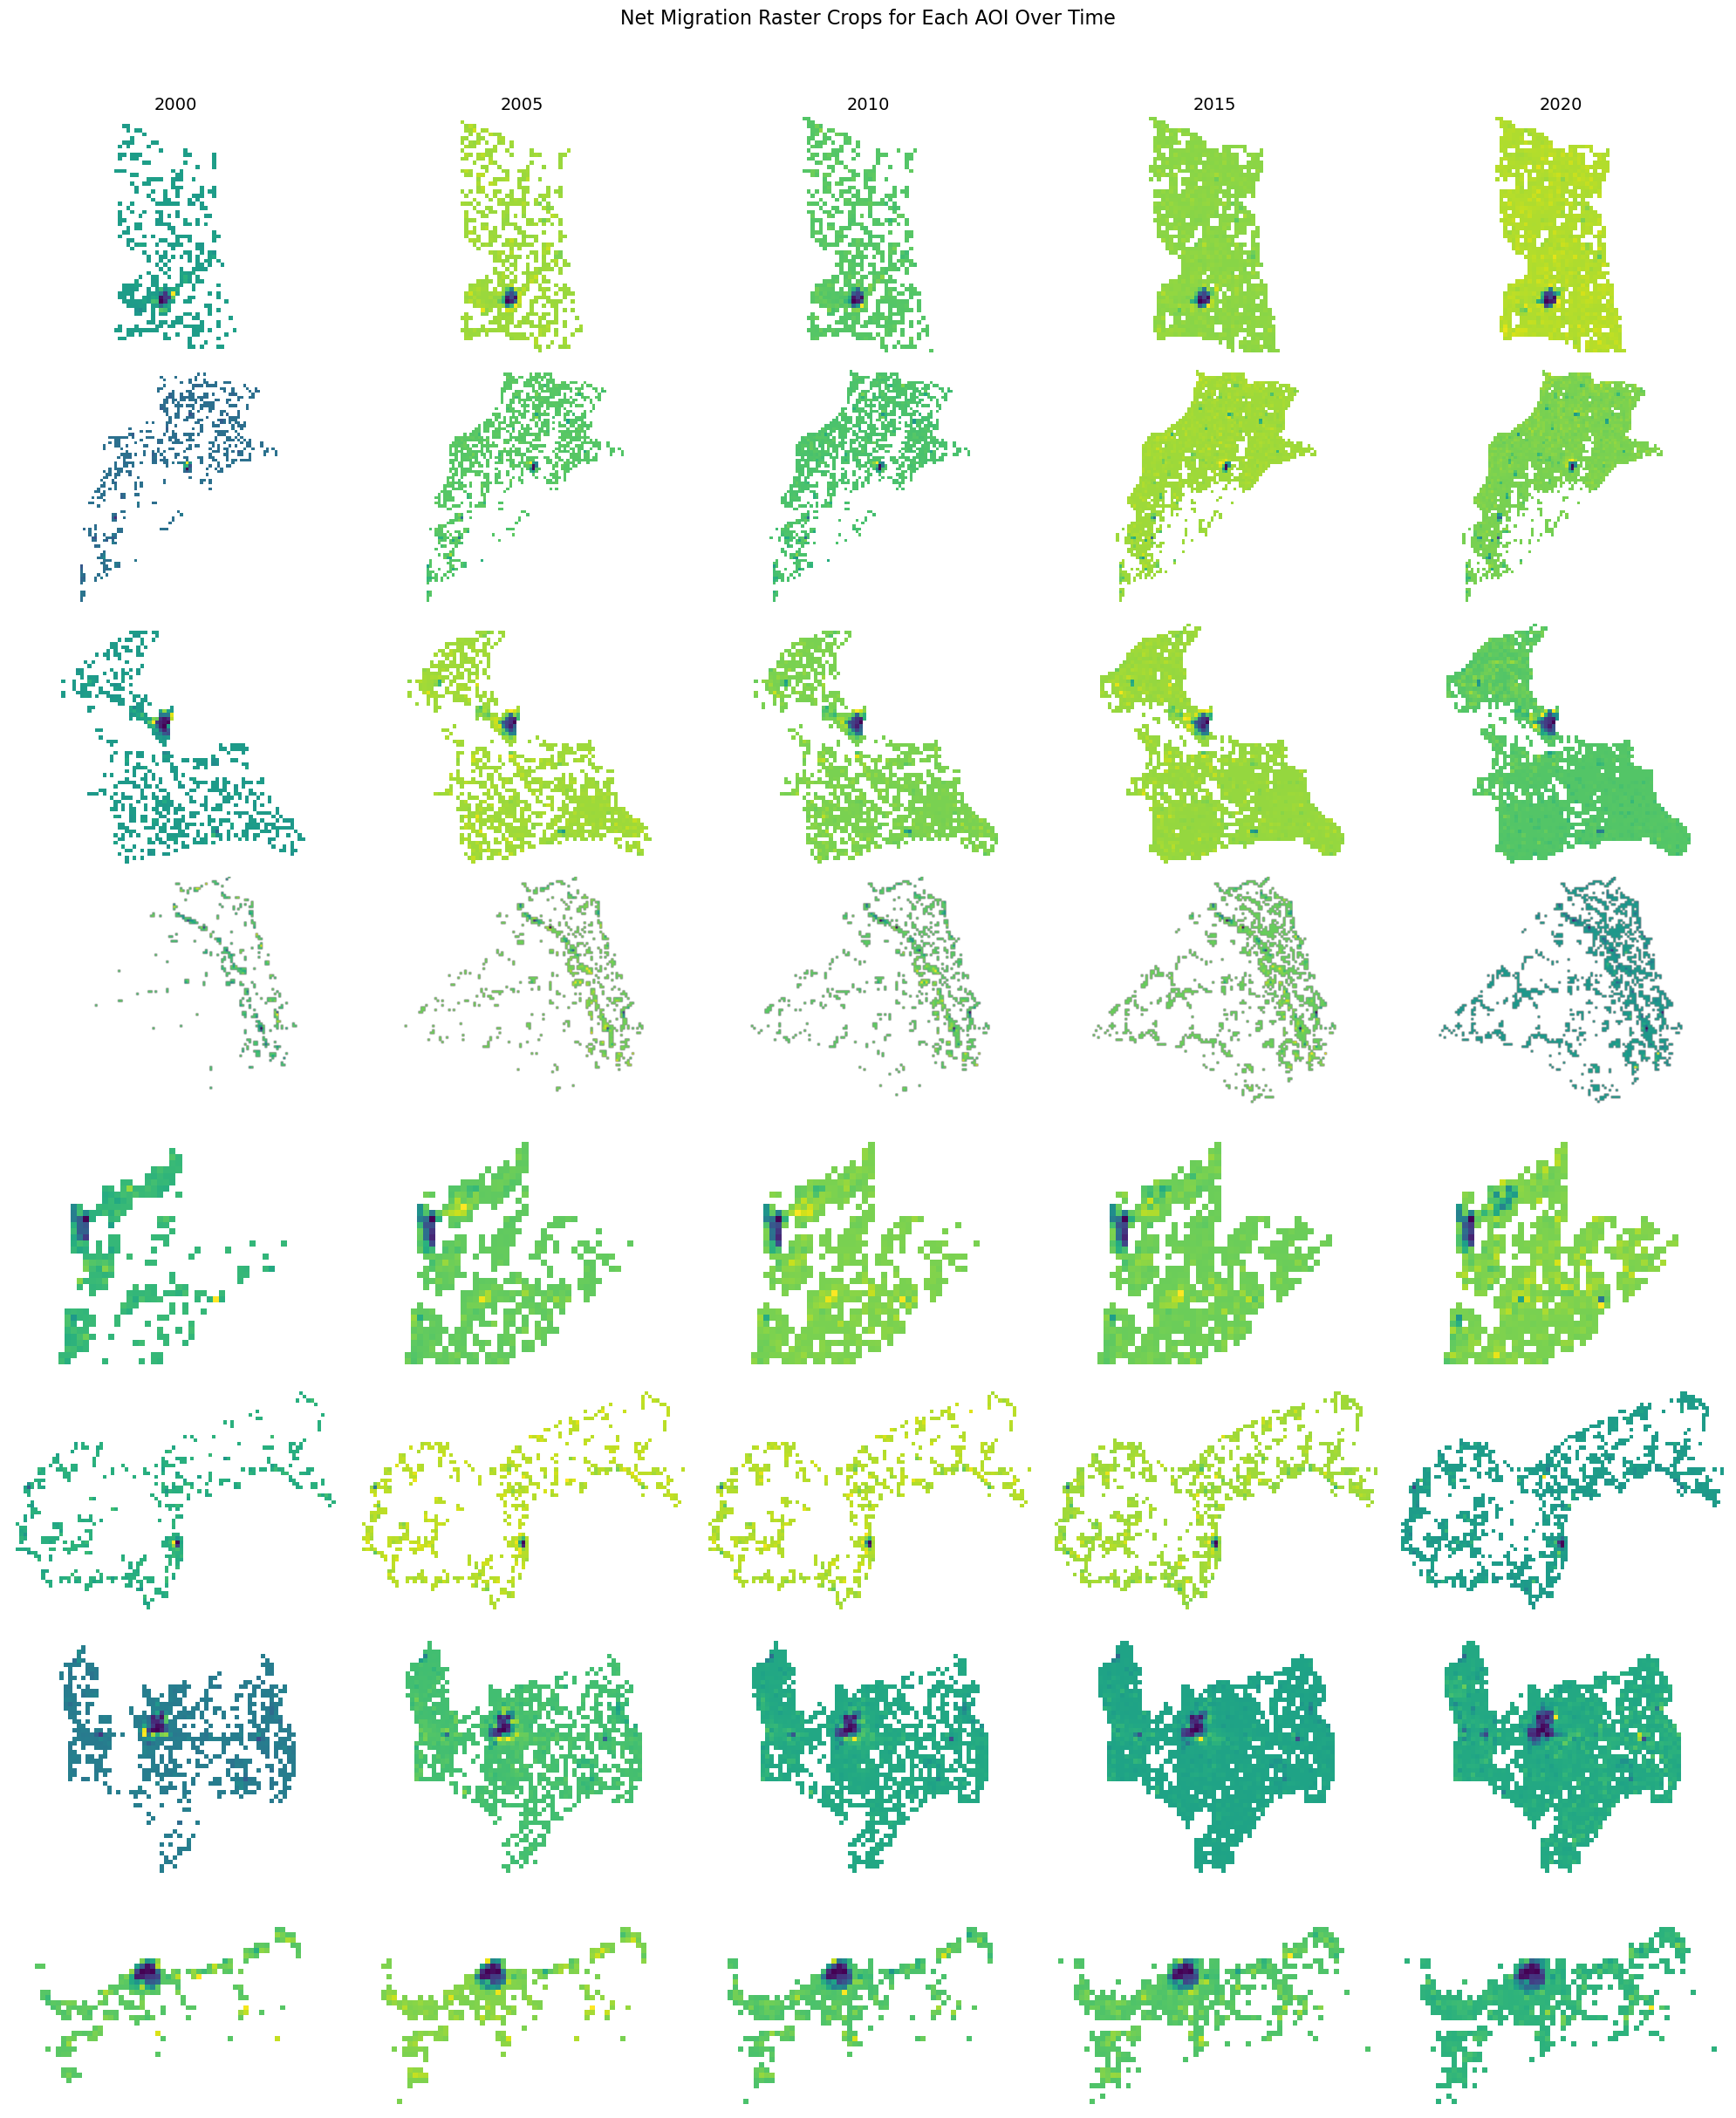

C:\Users\Khizer Zakir\AppData\Local\Temp\ipykernel_13212\1127202545.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Total Migration')


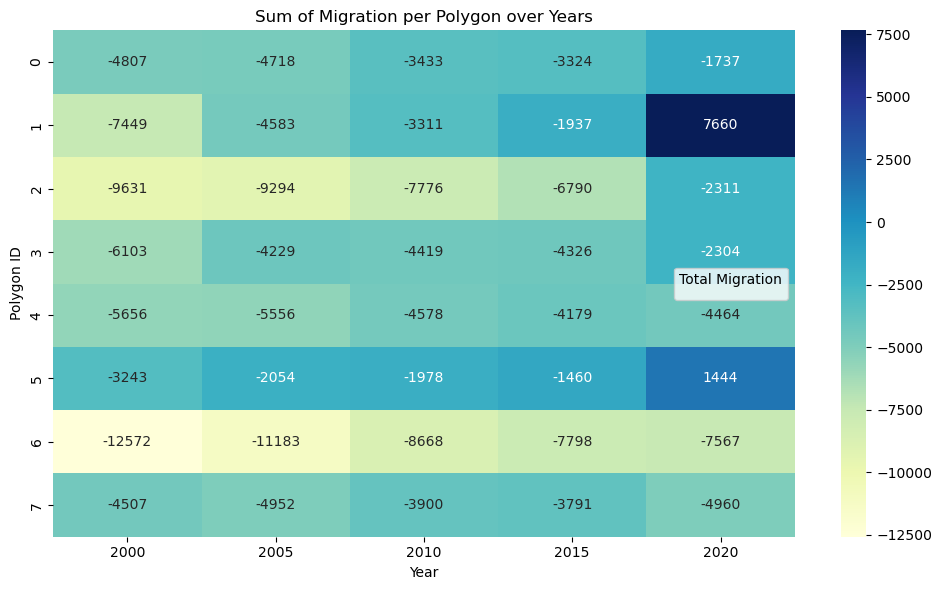

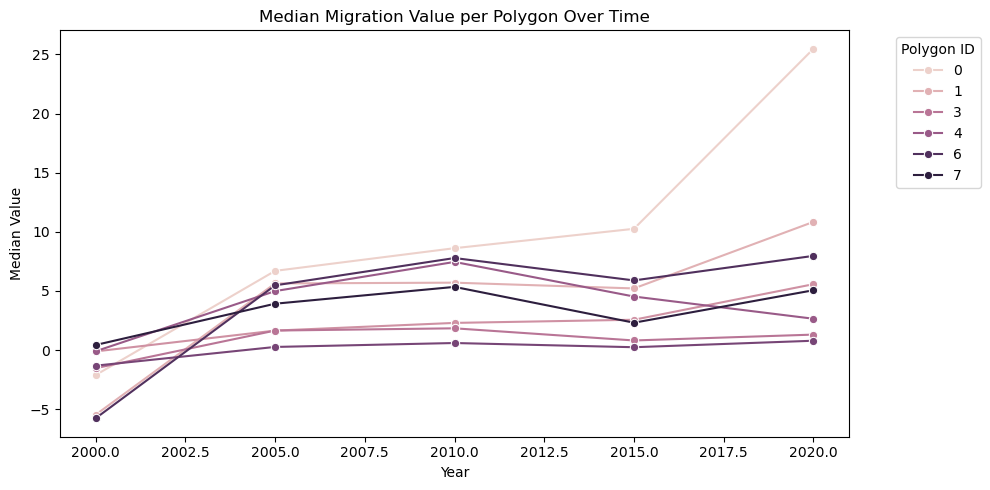

In [8]:

results_dict, summary_df = get_masks_and_stats(raster_paths_dict, shapefile_path)
plot_all_polygons_grid(results_dict)
plot_summary_stats(summary_df)

# Optionally export:
# summary_df.to_csv("polygon_migration_summary.csv", index=False)


In [ ]:
import os
import glob2
import h5netcdf
import xarray as xr
import pandas as pd
import geopandas as gpd
# import contextily as ctx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import shutil
import calendar
import hvplot.pandas
import earthaccess
import cdsapi
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")

print("All libraries imported successfully!")


## Access to climate variables data from APIs

There are so many data portals and access APIs. Here we will try to use ECMWF and CDS data APIs to get data for the AOI. 

To work with it you need to make sure the following:

- Have ***`.cdsapi`*** with
     - url: https://cds.climate.copernicus.eu/api
     - key: {you can get it from your CDS account} - You can make your account here: [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/user-guide)
     - Make sure you store the ***`.cdsapi`*** file in the %%USERS%% folder.

- BBOX details for your **AOI** and other parameters.


In [ ]:
# # Load the data
# import os
# import glob
# from zipfile import ZipFile

# with ZipFile('7177cec971b9f6b035229fb8d9e8df48.zip', 'r') as f:

# #extract in different directory
#     f.extractall()
# os.listdir()

In [ ]:
# Initialize the CDS API client
c = cdsapi.Client()

dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis_by_hour_of_day"],
    "variable": [
        "2m_temperature",
        "sea_surface_temperature",
        "total_precipitation",
        "leaf_area_index_high_vegetation"
    ],
    "year": [
        "2014", "2015", "2016",
        "2017", "2018", "2019",
        "2020", "2021", "2022",
        "2023", "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["12:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [16.97, -18.01, 11.5, -11.08] # north, west, south, east -- Bbox using :https://boundingbox.klokantech.com/ 
}

filename = c.retrieve(dataset, request, 'era5_monthly_sen_2014_2024.nc')
print(f"Downloaded file: {filename}")



In [ ]:
ds = xr.open_dataset(filename)
ds

In [ ]:

if "t2m" in ds:
    ds["t2m"] = ds["t2m"] - 273.15  # Kelvin to Celsius
ds['t2m'][131,:,:].plot()

In [ ]:
ds["valid_time"] = pd.to_datetime(ds["valid_time"])

# Variables to plot
variables = ["t2m", "tp", "sst"]

for var in variables:
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12), sharex=True, sharey=False)
    fig.suptitle(f"{var.upper()} Monthly Trends (2014-2024)", fontsize=16)
    
    # Flatten the 4x3 grid for easier indexing
    axes = axes.flatten()
    
    for month in range(1, 13):  
        ax = axes[month - 1]
        month_name = calendar.month_abbr[month]  # Convert number to name
        subset = ds[var].sel(valid_time=ds["valid_time"].dt.month == month)
        
        # Compute spatial mean to get a single time series
        mean_values = subset.mean(dim=["latitude", "longitude"])
        
        # Plot on the corresponding subplot
        sns.lineplot(x=mean_values["valid_time"], y=mean_values, ax=ax, label=f"{month_name}")
        
        ax.set_title(f"{month_name}")  # Use actual month name
        ax.set_xlabel("Year")
        ax.set_ylabel(var.upper())
        ax.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
# ds["valid_time"] = pd.to_datetime(ds["valid_time"])

# # Variables to animate
# variables = ["t2m", "tp", "sst"]

# Define geographical extent [West, East, South, North]
extent = [-18, -11, 12, 17]  # Modify as needed

for var in variables:
    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})

    # Add basemap features
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # Set zoom level
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

    # # Convert temperature from Kelvin to Celsius if needed
    # if var == "t2m":
    #     ds[var] = ds[var] - 273.15  # Kelvin to Celsius

    # Initial plot
    im = ds[var].isel(valid_time=0).plot(ax=ax, cmap="coolwarm", add_colorbar=False, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(im, ax=ax, orientation="vertical")

    def animate(i):
        im.set_array(ds[var].isel(valid_time=i).values.flatten())  # Update data
        ax.set_title(f"{var.upper()} - {str(ds.valid_time.values[i])[:10]}")

    # Create animation
    ani = animation.FuncAnimation(fig, animate, frames=len(ds.valid_time), interval=1000)

    writer = "ffmpeg" if shutil.which("ffmpeg") else "pillow"
    ext = "mp4" if writer == "ffmpeg" else "gif"

    # Save animation
    ani.save(f"{var}_animation.{ext}", writer=writer)

    plt.close(fig)  # Prevents inline display in notebooks

In [ ]:
# # Convert temperature from Kelvin to Celsius **before** the loop
# if "t2m" in ds:
#     ds["t2m"] = ds["t2m"] - 273.15  # Kelvin to Celsius

for var in variables:
    plt.figure(figsize=(14, 6))

    # Compute spatial mean
    mean_values = ds[var].mean(dim=["latitude", "longitude"])

    # Extract time index
    time_index = ds["valid_time"].values

    # Plot line chart
    plt.plot(time_index, mean_values, color="red", linestyle="-", marker="o")#, label="")

    plt.title(f"{var.upper()} - Aggregated Over 132 Months (2014-2024)")
    plt.xlabel("Time")
    plt.ylabel(f"{var.upper()} ({'°C' if var == 't2m' else 'units'})")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    plt.show()

### ***INTERPRETATION***

##### **1. Monthly Trends (2014-2024)**
The first image provides a grid of 12 subplots, each representing a specific month (January to December). 
- Each month shows variations in temperature over the years, with some months exhibiting a more consistent increase or decrease.
- Some months, such as December and April, exhibit a general upward trend, indicating potential warming patterns.

##### **2. Aggregated Trend (132 Months)**
The second image consolidates the monthly data into a single time series plot, giving a clearer picture of temperature variations across the years.
- There are significant fluctuations in temperature across months, likely due to seasonal effects and climatic variations. Despite fluctuations, there is an overall warming trend, particularly in recent years.

Important point to explore:
- The overall warming trend is evident, but the magnitude of the trend and its implications need further analysis
- Senegal, being in the **Sahel region**, is prone to droughts, and a decline in TP alongside rising T2M could indicate increasing aridity (nned to check)
- **Warmer SSTs** in the nearby Atlantic can influence rainfall patterns over Senegal, potentially **reducing precipitation** due to altered monsoon dynamics.   
- It would be useful to analyze SST anomalies alongside T2M to understand potential ocean-atmosphere interactions affecting Senegal’s climate.  

### ***NEXT STEPS***

- ***Overlaying*** settlement layer + pop layer [another proxy if available] to observe the general trend and make an agnostic guess about the mobility
- Understanding the mobility through an impact chain - Building on the anamolies, we can discover the major changes in the regions of interest or the country overall. And, how this may or may not have led to the mobility of people. 
- Open to suggestions